# 조건이 있는 생성 모델 cGAN

- GAN : 조건이 없는 생성 모델. 항상 랜덤인 결과

👉 y라는 조건을 입력해 원하는 결과를 정해주자! 이때 y는 어떤 정보라도 가능 ex) label

#### GAN 

D는 G(z)와 x를 입력으로 받아 진짜와 가짜를 구분한다.

![image](https://user-images.githubusercontent.com/86637320/133541638-8a3723fd-487e-42f6-a38f-bc1c2eb7c53b.png)

GAN : $\min _{G} \max _{D} V(D, G)=$
$\mathbb{E}_{x \sim p_{-} d a t a(x)}[\log D(x)]+\mathbb{E}_{z \sim p_{x}(z)}[\log (1-D(G(z)))]$

#### cGAN

y (one-hot vector)를 추가 정보로 입력해준다!

![image](https://user-images.githubusercontent.com/86637320/133541650-c7ab7c7d-1e8b-4816-a5f2-e522d0081635.png)

cGAN : $\min _{G} \max _{D} V(D, G)=$
$\mathbb{E}_{x \sim p_{\text {data }}(x)}[\log D(x \mid y)]+$
$\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z \mid y)))]$

___

# 복잡한 조건을 전달해주기

포켓몬 이미지 스케치

#### pix2pix

이미지를 입력 받아 원하는 다른 형태의 이미지로 변형 (image-to-image translation)

![image](https://user-images.githubusercontent.com/86637320/133564396-23a72b5d-2c1d-411d-b876-8165a337244f.png)


#### Generator

이미지 입력을 받아 이미지 출력

1. Auto-encoder

- Downsampling하면서 이미지의 중요 representation 학습

- Encoder의 핵심 정보 : 저차원으로 압축

![image](https://user-images.githubusercontent.com/86637320/133565858-b2de35bf-d939-4f7b-83f4-e2a9c1fdf233.png)

2. U-net

- encoder - decoder skip connection 존재 -> 더 많은 정보 전달 받아 이미지 생성 성능 개선

![image](https://user-images.githubusercontent.com/86637320/133567693-03408d82-345d-435d-82c1-9f2b355abf36.png)


U-Net 적용시 autoencoder때 보다 이미지 더 잘 생성 

![image](https://user-images.githubusercontent.com/86637320/133568356-cce9d2b9-06a6-4dc1-98ee-4490680757b8.png)


Auto-encoder만으로 충분히 이미지 생성 가능!

- input과 output image 사이 L2(MSE), L1(MAE) 같은 손실을 계산 후 역전파하여 네트워크 학습

생성 이미지가 흐리다는 단점 ❗

![image](https://user-images.githubusercontent.com/86637320/133570169-e113f79b-2c61-4ed0-9655-f48ad611ded4.png)


#### GAN으로 구성해야 더 좋은 이미지를 생성할 수 있다.

___

#### Discriminator

기존 GAN : 전체 이미지의 압축된 1차원 정보를 가지고 판별 -> 이걸로 충분한가?

이미지의 특성(patch 내 픽셀끼리 연관성이 크다)고려해 판별하면 더 좋을 것.

👉 PatchGAN

전체를 부분으로 나눠 각각 **real/fake** 판단 -> 각각의 판단 확률의 평균을 내 최종 출력 

image patch를 사용하기 때문에 **PatchGAN**이라고도 불린다.

![image](https://user-images.githubusercontent.com/86637320/133570819-d4b3cb7c-604e-4a6d-bf88-7c780e3cadba.png)

#### 실제로 적절한 Patch(70x70) 설정했을 때 좋은 결과를 얻을 수 있었다.

입력 이미지 : 286x286 . 숫자 : Patch size

![image](https://user-images.githubusercontent.com/86637320/133573493-3c5a1979-a32c-4524-bfe5-de1b7a1a69e2.png)

___

## 1. 데이터 전처리

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


데이터 확인

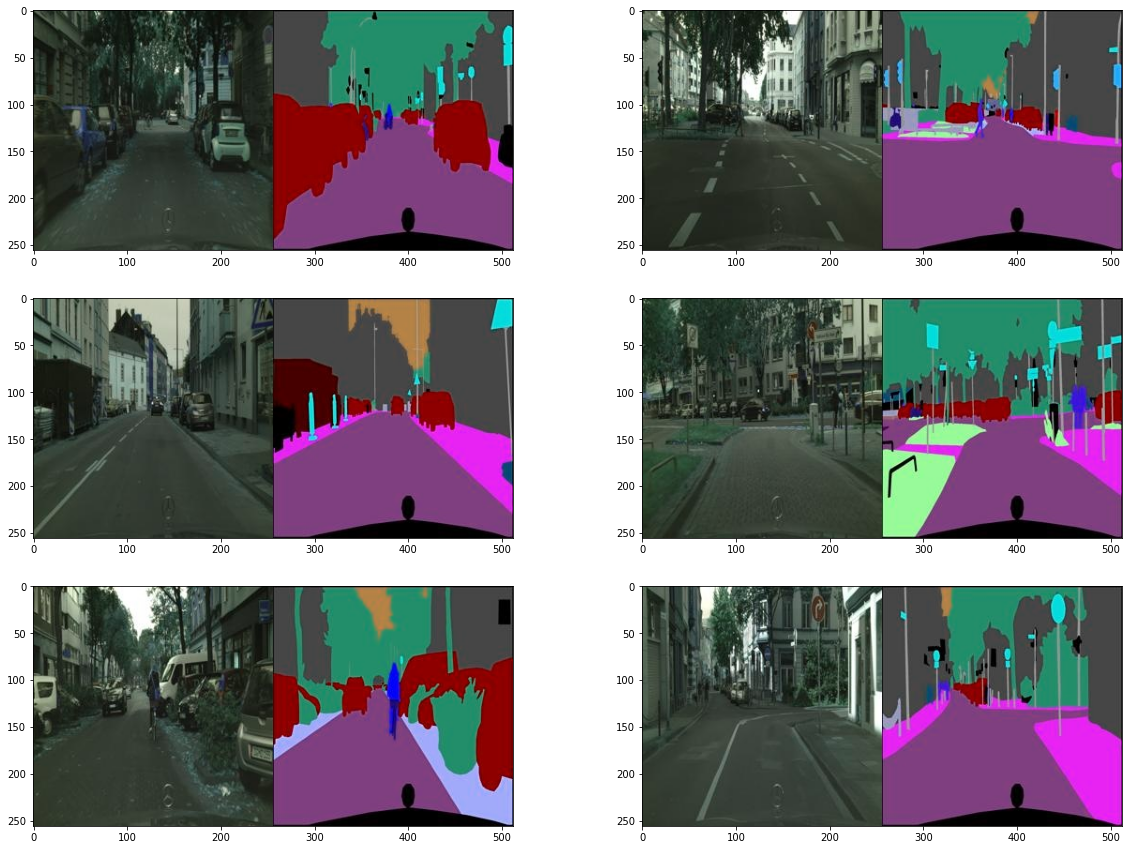

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지 크기 확인

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


#### Seg-map / 도로 이미지 분리

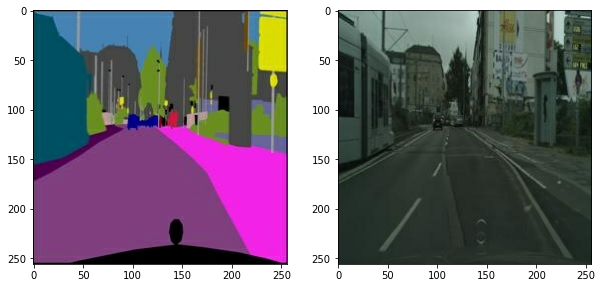

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): #복원
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32) #
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(seg), normalize(colored)

f = data_path + os.listdir(data_path)[1]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

데이터가 너무 적기 때문에 data_augmentation 진행

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(seg, colored):
    stacked = tf.concat([seg, colored], axis=-1) #6 channel
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: #50% 확률로 reflection, constant padding 적용
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out) 
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

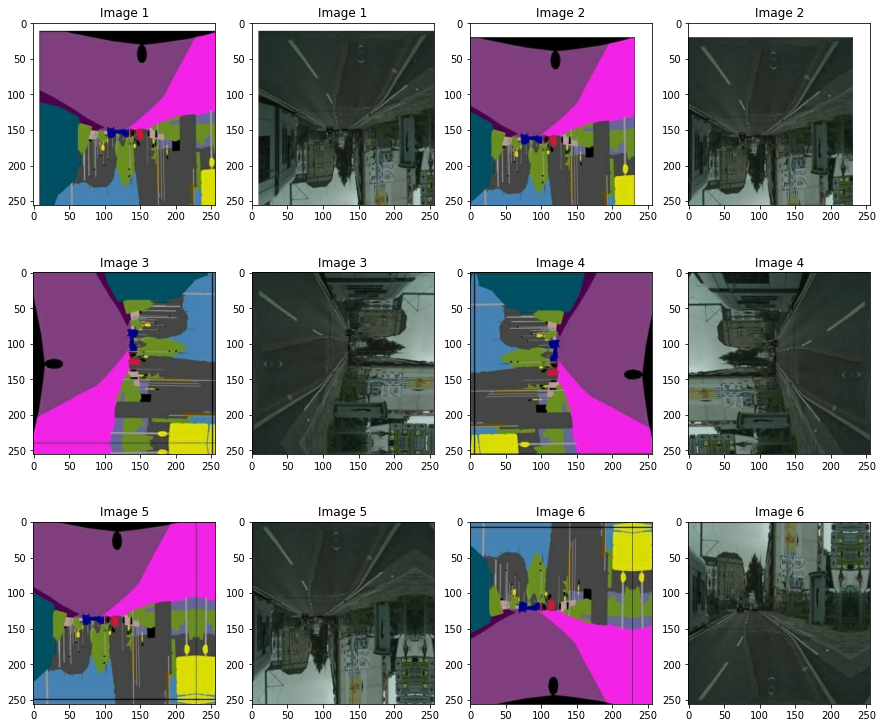

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_colored = apply_augmentation(seg, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

#### 전체 데이터셋에 적용

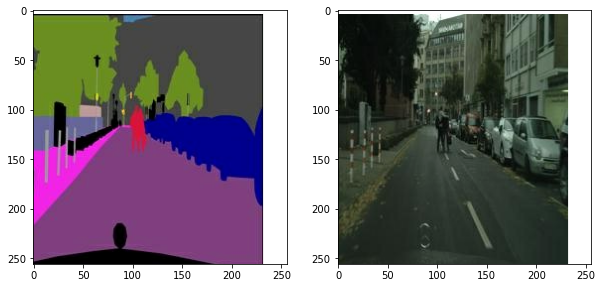

In [7]:
from tensorflow import data

def get_train(img_path):
    seg, colored = load_img(img_path)
    seg, colored = apply_augmentation(seg, colored)
    return seg, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. 모델 구성

#### U-net based model

(1) Generator

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

#### 기존 Auto-encoder 구조에서 Skip-connection 추가!

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] #encoder의 마지막 출력은 skip connection 적용할 필요 없으므로
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): #skip-connection은 뒤 feature 부터 진행되므로
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

#### U-net Generator 구조 확인

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

#### Auto-encoder 구조 보다 U-net 구조 사용 시 파라미터 수가 늘었다.

- Skip-connection 때문에!

Auto-encoder : 4000만개,  U-net : 5500만개

___

(2) Discriminator

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

#### custom_pad의 각 출력의 크기 확인

input : 128x128x32 -> zero_padding : 130x130x32 -> conv2d : 127x127x64

In [12]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


#### custom_pad : 출력 크기 1씩 감소

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [14]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

#### 임의 입력

학습이 안됐지만 이미지 생성엔 성공했다.

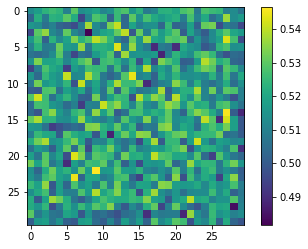

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

___

## 3. 훈련 구성

![image](https://user-images.githubusercontent.com/86637320/133648366-6229779d-6001-4f7f-bfa0-6f9d1cd06590.png)

#### (1) 손실 함수

L1 + GAN의 손실 함수로 구성

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

#### (2) Optimizer

논문과 동일하게 구성

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

#### (3) Train_step

L1 loss의 가중치를 100으로 설정

In [18]:
@tf.function
def train_step(seg, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(seg, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg, fake_colored, training=True)
        real_disc = discriminator(seg, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

#### 10 에포크 학습해보기

In [19]:
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (seg, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8286                     
L1_loss:0.3683                     
Discriminator_loss:1.3473

EPOCH[1] - STEP[20]                     
Generator_loss:1.0494                     
L1_loss:0.2849                     
Discriminator_loss:1.3884

EPOCH[1] - STEP[30]                     
Generator_loss:0.8633                     
L1_loss:0.1905                     
Discriminator_loss:1.3414

EPOCH[1] - STEP[40]                     
Generator_loss:0.9321                     
L1_loss:0.2395                     
Discriminator_loss:1.4180

EPOCH[1] - STEP[50]                     
Generator_loss:1.0354                     
L1_loss:0.1931                     
Discriminator_loss:1.1918

EPOCH[1] - STEP[60]                     
Generator_loss:1.0619                     
L1_loss:0.2162                     
Discriminator_loss:1.0482

EPOCH[1] - STEP[70]                     
Generator_loss:1.0004                     
L1_loss:0.1918                    

___

## 훈련된 모델 이용해 도로 이미지 생성하기 

valid 이미지 활용!

In [28]:
valid_dir = os.getenv("HOME")+'/aiffel/conditional_generation/data/cityscapes/val/'

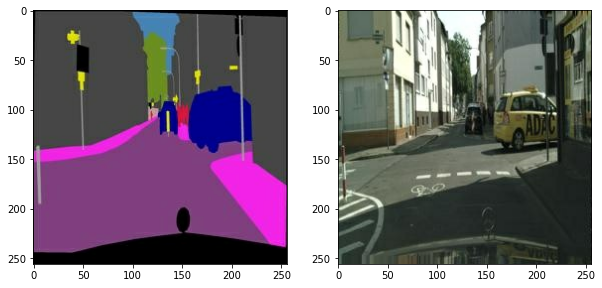

In [36]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): #복원
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32) #
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(seg), normalize(colored)

f = valid_dir + os.listdir(valid_dir)[0]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [37]:
valid_images = data.Dataset.list_files(valid_dir+ "*.jpg")
valid_images = valid_images.map(load_img)

#### 도로 이미지 생성하기

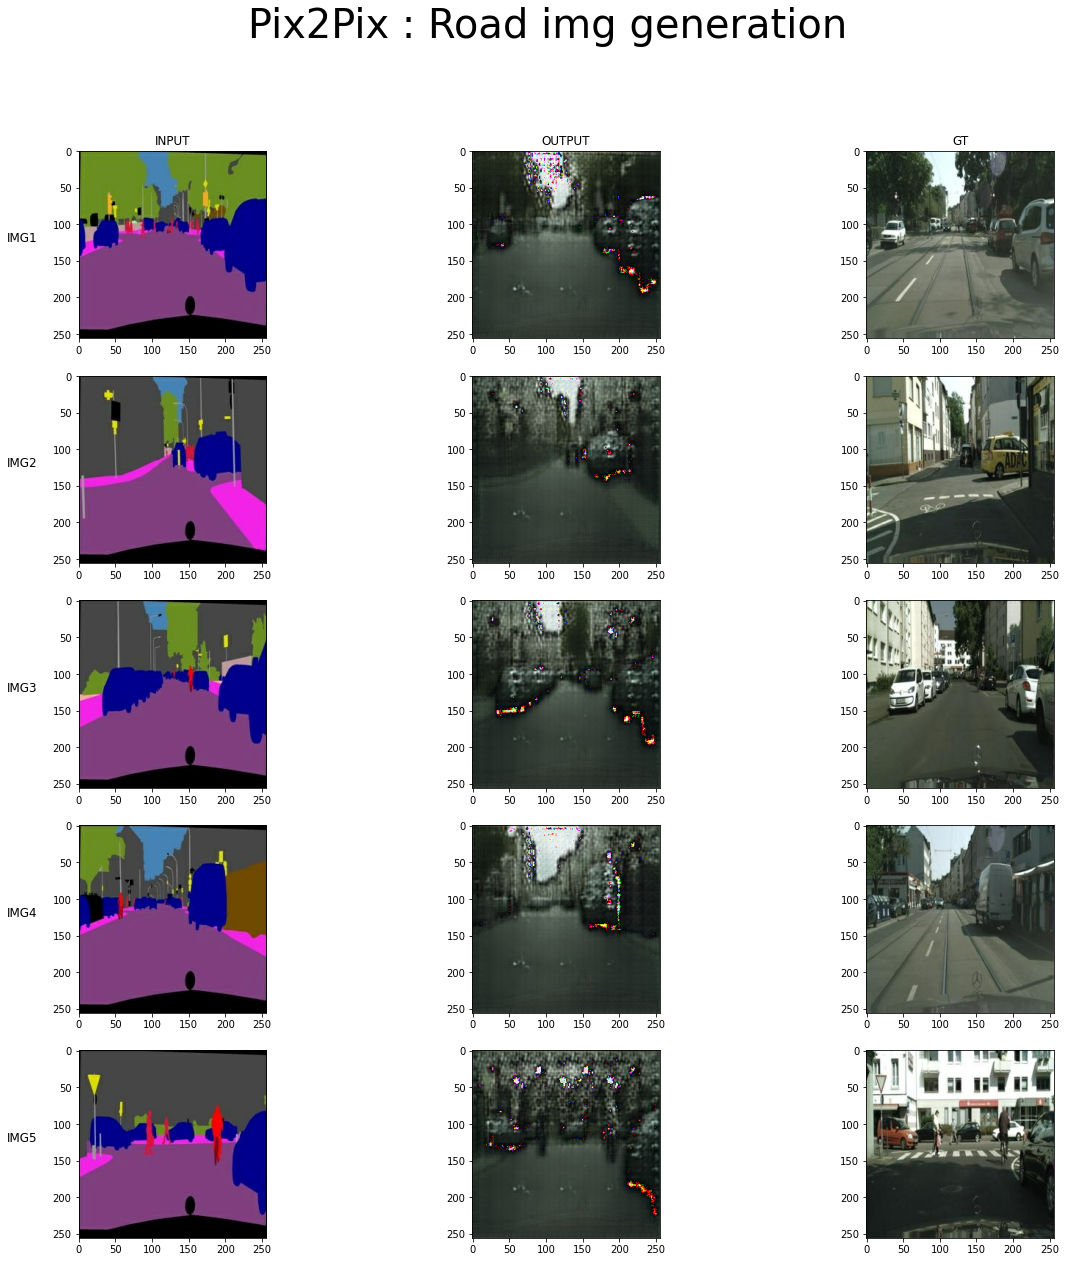

In [72]:
fig,axes = plt.subplots(5,3,figsize=(20,20))

cols = ['INPUT','OUTPUT','GT'] #col 이름
rows = ['IMG1','IMG2','IMG3','IMG4','IMG5'] #row 이름

for i,(seg,colored) in enumerate(valid_images): 
    
    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)
    row, col = i, 0
    
    axes[row][col].imshow(denormalize(seg))
    axes[row][col+1].imshow(pred[0])
    axes[row][col+2].imshow(denormalize(colored))
    

for ax, col in zip(axes[0], cols): #columns 공통 이름 설정
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows): #rows 공통 이름 설정
    ax.set_ylabel(row, labelpad=30,rotation=0, size='large')
    
plt.suptitle('Pix2Pix : Road img generation',fontsize=40) #공통 타이틀 설정
plt.show()

___

# 정리

**도로 이미지**와 도로 이미지에 대한 **레이블 정보**(Segmentation-map)으로 pix2pix모델을 훈련했다. 이를 통해 레이블 정보만 가지고 도로 이미지를 생성할 수 있음을 확인했다. Train 데이터가 1000장 정도로 매우 적었기 때문에 reflection, constant padding과 random crop, random flip을 통해 data augmentation을 진행했다. 5장의 데이터로 생성 결과를 확인해 봤는데 10 epochs만 진행한 것 치고는 굉장히 괜찮은 결과가 나왔다.